In [ ]:
import sys
import yaml
sys.path.append("..\..")

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from src.nn.train.MelodyNet_train import PLMelodyNet
from src.nn.inference.MelodyNet_inference import MelodyNetInference
from src.data.datasets.melody_dataset import MelodyDataset
from src.data.structures.melody import Melody
from src.data.loaders.melody_loader import get_melody_dataloader

In [2]:
split = "test"
file = "verse_2"

In [3]:
audio = f"..\\..\\datasets\\MelodyNet\\processed\\{split}\\audio\\{file}.wav"
midi = f"..\\..\\datasets\\MelodyNet\\processed\\{split}\\labels\\{file}.mid"

In [4]:
melody_inference = MelodyNetInference("..\\..\\src\\nn\\weights\\MelodyNet\\best.ckpt")

Preprocessing audio: 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


<Axes: title={'center': 'Target melody'}, xlabel='Время, с'>

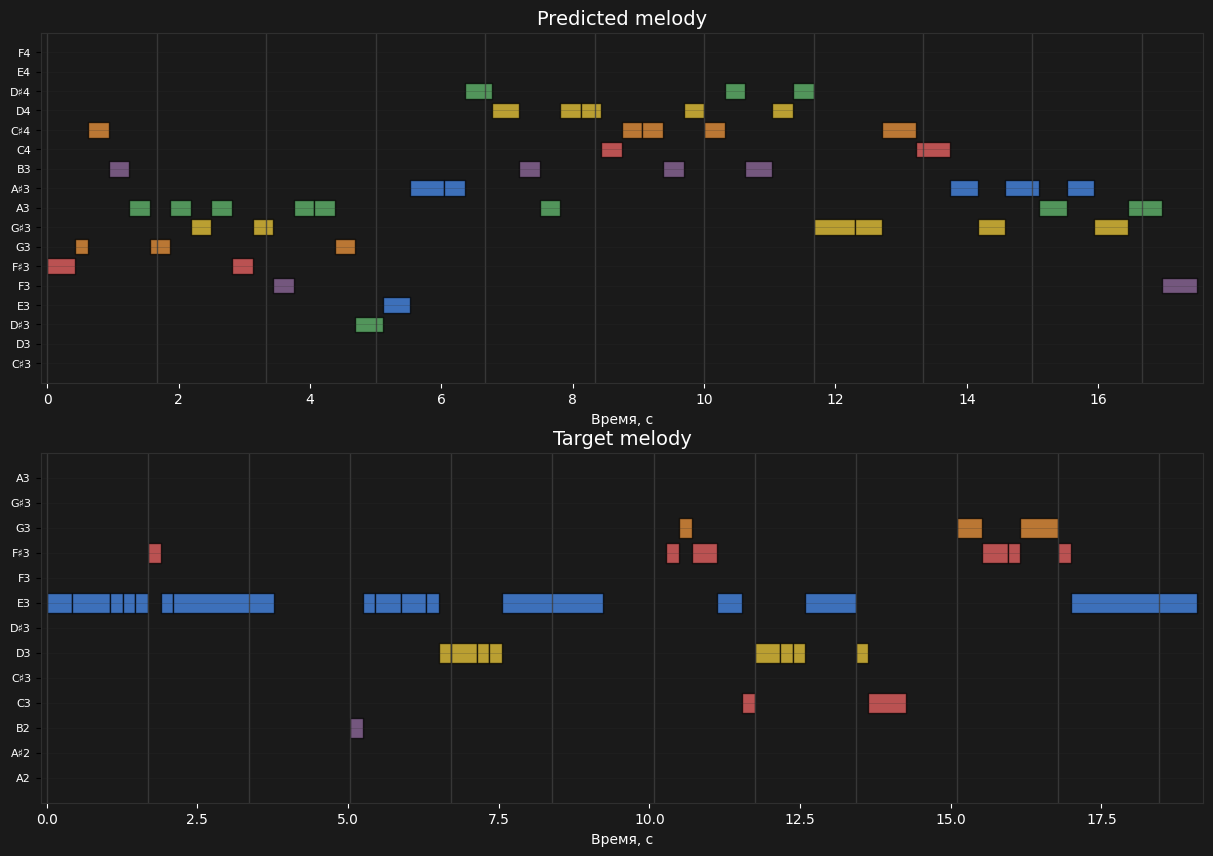

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.patch.set_facecolor('#1A1A1A')

melody = melody_inference.extract_melody(audio, tempo=None)
melody.visualize(ax=ax[0], title="Predicted melody")

target = Melody.from_midi(midi)
target.visualize(ax=ax[1], title="Target melody")

In [3]:
def bootstrap_test(
    model: PLMelodyNet, 
    dataset: MelodyDataset, 
    n_bootstraps=1000, 
    num_workers=4, 
    confidence_level=0.95
) -> dict[str, dict[str, float]]:
    """Оценивает модель с помощью бутстрапа и возвращает доверительные интервалы для метрик.
    
    :param PLMelodyNet model: Обученная модель PLMelodyNet
    :param MelodyDataset dataset: Тестовый датасет
    :param int batch_size: Размер батча
    :param int num_workers: Количество рабочих для загрузки данных
    :param float confidence_level: Уровень доверия для интервалов
    
    :return dict[str, dict[str, float]]: Метрики с доверительными интервалами
    """
    model.eval()
    device = next(model.parameters()).device
    
    bootstrap_metrics = {
        'mse_freqs_hz': [],
        'mse_durations_beats': [],
        'mse_seq_len': [],
        'total_score': [],
        "loss": []
    }
     
    loader = get_melody_dataloader(
        dataset,
        batch_size=1,
        num_workers=num_workers,
        shuffle=False
    )

    all_samples = []
    for batch in tqdm(loader, desc="Loading test samples"):
        all_samples.append(batch)

    for _ in tqdm(range(n_bootstraps), desc="Calculating CI"):

        for metric in model.test_metrics.values():
            metric.reset()
        
        total_loss = 0
        num_batches = 0

        bootstrap_indices = np.random.choice(len(all_samples), size=len(all_samples), replace=True)

        for idx in bootstrap_indices:
            batch = all_samples[idx]
            batch = [x.to(device) if isinstance(x, torch.Tensor) else x for x in batch]

            spectrograms = batch[0]
            targets = batch[1:]
            
            with torch.no_grad():
                preds = model(spectrograms)
                loss = model._compute_losses(preds, targets)[0]
                model._compute_denormalized_metrics(preds, targets, model.test_metrics)

                total_loss += loss.item()

            num_batches += 1
        
        avg_loss = total_loss / num_batches
        mse_freqs = model.test_metrics['mse_freqs_hz'].compute().item()
        mse_durations = model.test_metrics['mse_durations_beats'].compute().item()
        mse_seq_len = model.test_metrics['mse_seq_len'].compute().item()
        total_score = mse_freqs + mse_durations + mse_seq_len
        
        bootstrap_metrics['loss'].append(avg_loss)
        bootstrap_metrics['mse_freqs_hz'].append(mse_freqs)
        bootstrap_metrics['mse_durations_beats'].append(mse_durations)
        bootstrap_metrics['mse_seq_len'].append(mse_seq_len)
        bootstrap_metrics['total_score'].append(total_score)
    
    alpha = 1 - confidence_level
    results = {}
    
    for metric_name, values in bootstrap_metrics.items():
        lower_percentile = alpha / 2 * 100
        upper_percentile = (1 - alpha / 2) * 100
        
        mean_value = np.mean(values)
        std_value = np.std(values)
        lower_bound = np.percentile(values, lower_percentile)
        upper_bound = np.percentile(values, upper_percentile)
        
        results[metric_name] = {
            'mean': mean_value,
            'std': std_value,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
        }
    
    return results

In [4]:
with open("../../src/nn/configs/MelodyNet_train.yaml") as stream:
    config = yaml.safe_load(stream)

    batch_size = int(config['batch_size'])
    num_workers = int(config['num_workers'])
    epochs = int(config['epochs'])
    log_every_n_steps = int(config['log_every_n_steps'])


model = PLMelodyNet.load_from_checkpoint("../../src/nn/weights/MelodyNet/best.ckpt", **config)
model.eval()

test_dataset = MelodyDataset.from_path("../../datasets/MelodyNet/processed/test")

bootstrap_results = bootstrap_test(
    model=model,
    dataset=test_dataset,
    num_workers=int(config['num_workers']),
)

Calculating CI: 100%|██████████| 1000/1000 [36:01<00:00,  2.16s/it]


In [ ]:
metric_names = {
    'loss': 'Normalized MSE',
    'total_score': 'Denormalized MSE',
    'mse_freqs_hz': 'MSE Frequencies (Hz)',
    'mse_durations_beats': 'MSE Durations (beats)',
    'mse_seq_len': 'MSE Sequence Length',
}
data = []

for metric_name, values in bootstrap_results.items():
    mean = values['mean']
    std = values['std']
    lower = values['lower_bound']
    upper = values['upper_bound']
    
    display_name = metric_names[metric_name]

    data.append({
        'Metric': display_name,
        'Mean': mean,
        'Std': std,
        'Lower Bound': lower,
        'Upper Bound': upper,
    })

pd.set_option('display.float_format', '{:.4f}'.format)
pd.DataFrame(data)

,Metric,Mean,Std,Lower Bound,Upper Bound
0,MSE Frequencies (Hz),93512.8642,6305.6244,82004.1086,105886.6779
1,MSE Durations (beats),1.4423,0.1425,1.1901,1.7310
2,MSE Sequence Length,68.2968,4.3351,59.6667,77.0052
3,Denormalized MSE,93582.6033,6305.6982,82066.5118,105952.5606
4,Normalized MSE,0.0927,0.0039,0.0852,0.1005
